# Lungs Auscultation Audios 

The auscultation is a technique to explore internal organs of the human body through the stetoscope in order to identify sounds whose are involved in some desease, like crackles and wheezes. These sounds can be identified in a time-frequency analysis, in which several statistic indices can be calculated (Variance, Range, Moving Average, Spectrum average) to build models that help to automatize the diagnosis of Crackles and Wheezes, or even some desease.

This project develops models of **regression and classification** with some of the indices described above using the data set I created in one of my university projects, in which a database of auscultation audios is analyzed, extracting each respiratory cycle from several auscultations performed on 126 patients.

The complete project can be found clicking [here](https://github.com/santiagortiiz/Lungs-Auscultation-Signals.git).

And The original audios Database can be found clicking [here](https://www.kaggle.com/vbookshelf/respiratory-sound-database)

## Let's start by importing principle libraries

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load the dataset as a DataFrame

The dataset describes each of the 126 patients in two ways, the first of which details their basic information such as age, sex, weight, BMI, and their identification. And the second describes each respiratory cycle including start time, end time, `pathologies detected`, status and `statistical indices`.

Note: The status describes the patient as follows:                                       
**State**                                                                              
0 -> Healthy (Respiratory cycle without Crackles or Wheezes)                                       
1 -> Respiratory cycle with Crackles                                       
2 -> Respiratory cycle with Wheezes                                       
3 -> Respiratory cycle with Both (Crackles and Wheezes)                                       

In [274]:
df = pd.read_excel('auscultation_features.xlsx')
df

,patient_ID,Diagnosis,age,sex,IMC,weight,height,adq_format,start,end,crackles,wheezes,state,Var,Range,Coarse_Av,Fine_Av,Spectrum Av
0,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,0.036,0.579,0,0,0,0.000048,0.113594,0.000446,0.000599,2.537207e-08
1,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,0.579,2.450,0,0,0,0.000066,0.159031,0.012435,-0.001276,3.532798e-08
2,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,2.450,3.893,0,0,0,0.000044,0.115345,-0.101963,-0.000701,2.213387e-08
3,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,3.893,5.793,0,0,0,0.000074,0.187316,-0.113660,-0.000223,3.485673e-08
4,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,5.793,7.521,0,0,0,0.000036,0.117565,-0.017593,-0.001040,1.806783e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,11.721,13.693,1,0,1,0.000015,0.056514,-0.005161,-0.005630,7.528343e-09
6894,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,13.693,15.536,0,0,0,0.000026,0.107412,-0.018191,-0.000332,1.279829e-08
6895,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,15.536,17.493,0,0,0,0.000017,0.089678,0.002857,0.005618,8.751189e-09
6896,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,17.493,19.436,1,0,1,0.000018,0.059962,-0.004191,0.002940,8.975479e-09


In [133]:
len(df)

6898

## Preparation required based on missing data

Lets see what proportion of our dataset is `missing` and if it requires some cleaning:

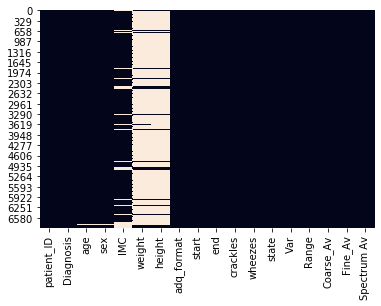

In [134]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [135]:
print(np.sum(df.isnull()==True))

patient_ID        0
Diagnosis         0
age              61
sex              61
IMC             894
weight         6149
height         6172
adq_format        0
start             0
end               0
crackles          0
wheezes           0
state             0
Var               0
Range             0
Coarse_Av         0
Fine_Av           0
Spectrum Av       0
dtype: int64


## Cleaning dataset

The models in which I am interested, just need the statistical features and the diagnosis, so let's drop IMC, weight, height and the adquisition format columns:

In [136]:
df.drop(['IMC','weight','height','adq_format'], axis=1, inplace=True)
features = df.columns
df

,patient_ID,Diagnosis,age,sex,start,end,crackles,wheezes,state,Var,Range,Coarse_Av,Fine_Av,Spectrum Av
0,101,URTI,3.0,F,0.036,0.579,0,0,0,0.000048,0.113594,0.000446,0.000599,2.537207e-08
1,101,URTI,3.0,F,0.579,2.450,0,0,0,0.000066,0.159031,0.012435,-0.001276,3.532798e-08
2,101,URTI,3.0,F,2.450,3.893,0,0,0,0.000044,0.115345,-0.101963,-0.000701,2.213387e-08
3,101,URTI,3.0,F,3.893,5.793,0,0,0,0.000074,0.187316,-0.113660,-0.000223,3.485673e-08
4,101,URTI,3.0,F,5.793,7.521,0,0,0,0.000036,0.117565,-0.017593,-0.001040,1.806783e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226,Pneumonia,4.0,M,11.721,13.693,1,0,1,0.000015,0.056514,-0.005161,-0.005630,7.528343e-09
6894,226,Pneumonia,4.0,M,13.693,15.536,0,0,0,0.000026,0.107412,-0.018191,-0.000332,1.279829e-08
6895,226,Pneumonia,4.0,M,15.536,17.493,0,0,0,0.000017,0.089678,0.002857,0.005618,8.751189e-09
6896,226,Pneumonia,4.0,M,17.493,19.436,1,0,1,0.000018,0.059962,-0.004191,0.002940,8.975479e-09


Then, notice that only 61 values of the age and sex columns are missing, so there are two options:

1) Discard the missing data: df = df.dropna()                                                    
2) Impute the missing data

#### Lets go ahead imputing these data with the **scikit learn** library using the **SimpleImputer** class

In [8]:
from sklearn.impute import SimpleImputer

In [137]:
imp = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imp.fit_transform(df), columns = features)

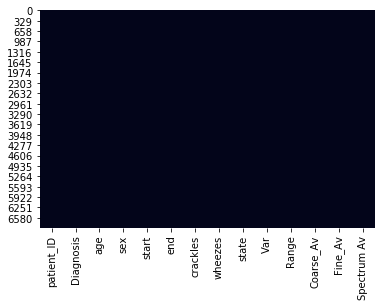

patient_ID     0
Diagnosis      0
age            0
sex            0
start          0
end            0
crackles       0
wheezes        0
state          0
Var            0
Range          0
Coarse_Av      0
Fine_Av        0
Spectrum Av    0
dtype: int64


In [138]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()
print(np.sum(df.isnull()==True))

# Scaling between -1:1 (Normalization with Sckit Learn)

In [11]:
from sklearn import preprocessing

In [218]:
df.loc[:, 'Var':'Spectrum Av'] = preprocessing.scale(df.loc[:, 'Var':'Spectrum Av'])
df['Intercept'] = 1
df

,patient_ID,Diagnosis,age,sex,start,end,crackles,wheezes,state,Var,Range,Coarse_Av,Fine_Av,Spectrum Av,Intercept
3153,158,COPD,63,M,10.276,12.73,0,0,0,-0.333874,-0.252502,-0.00854766,0.342765,-0.335266,1
2195,144,Healthy,3,M,11.836,13.736,0,0,0,-0.408888,-0.877265,0.0520217,0.0109757,-0.406949,1
2130,141,COPD,66,M,18.279,19.307,0,1,2,-0.400046,-0.752192,-0.0269303,-0.025986,-0.397925,1
2502,151,COPD,75,M,12.179,15.701,1,0,1,-0.384935,-0.603046,0.23697,0.0311238,-0.383317,1
2176,143,Healthy,0.25,F,17.25,18.35,0,0,0,-0.409529,-0.853852,-0.00188055,0.0171662,-0.407659,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6284,211,COPD,70,F,8.894,10.235,0,0,0,-0.147175,-0.260528,0.1067,-1.51089,-0.1367,1
411,109,COPD,84,F,8.55,10.674,0,0,0,-0.233228,0.437392,0.0418405,0.0393682,-0.2357,1
1511,130,COPD,85,F,18.156,19.194,1,0,1,-0.284592,-0.579716,0.0209268,-0.0706335,-0.283251,1
6118,207,COPD,63,F,1.261,4.583,0,0,0,-0.160055,0.0678598,0.072842,0.630796,-0.160613,1


# Shuffle the dataset because:

1) Shuffled samples will help us avoid areas of the model that under/overfil the data

2) If we evaluate a movel based on data it has seen before, we may overestimate its performance

In [219]:
df = df.sample(frac=1)
df

,patient_ID,Diagnosis,age,sex,start,end,crackles,wheezes,state,Var,Range,Coarse_Av,Fine_Av,Spectrum Av,Intercept
2924,156,COPD,80,M,14.535,17.589,1,1,3,-0.401156,-0.798398,0.200927,0.106203,-0.399382,1
1661,133,COPD,68,M,8.375,10.78,0,0,0,-0.274294,-0.331413,0.121491,-0.266822,-0.270577,1
1605,133,COPD,68,M,7.375,9.946,1,0,1,0.565438,1.09739,0.00611665,1.09806,0.586861,1
343,107,COPD,75,F,16.696,18.887,1,0,1,0.2183,1.93693,0.59383,0.31942,0.21216,1
1331,130,COPD,85,F,5.937,7.83,1,0,1,0.474795,0.825708,3.22218,-0.981882,0.517281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,205,COPD,45,M,15.994,19.688,1,0,1,-0.32124,0.704738,-0.0072496,0.164282,-0.323834,1
2361,147,COPD,77,M,8.364,12.794,0,1,2,0.142992,0.875651,-0.0204281,-0.101878,0.139608,1
1020,130,COPD,85,F,0.697,2.423,1,0,1,-0.39095,-0.7327,0.906886,0.378545,-0.389354,1
4174,174,COPD,68,M,0.593,3.331,0,1,2,-0.387805,-0.736466,-0.082893,-0.168168,-0.385898,1


**Labels to predict:**

In [220]:
y = df['state'].values.reshape(-1,1)  # -1 means that calculate the dimension of rows, but have 1 column
y = y.tolist()
y[:10]

[[3], [0], [1], [1], [1], [0], [1], [0], [0], [2]]

**Features used to predict:**

In [221]:
X = pd.concat([df['Intercept'], df.loc[:, 'Var':'Spectrum Av']], axis=1)
X

,Intercept,Var,Range,Coarse_Av,Fine_Av,Spectrum Av
2924,1,-0.401156,-0.798398,0.200927,0.106203,-0.399382
1661,1,-0.274294,-0.331413,0.121491,-0.266822,-0.270577
1605,1,0.565438,1.09739,0.00611665,1.09806,0.586861
343,1,0.2183,1.93693,0.59383,0.31942,0.21216
1331,1,0.474795,0.825708,3.22218,-0.981882,0.517281
...,...,...,...,...,...,...
5995,1,-0.32124,0.704738,-0.0072496,0.164282,-0.323834
2361,1,0.142992,0.875651,-0.0204281,-0.101878,0.139608
1020,1,-0.39095,-0.7327,0.906886,0.378545,-0.389354
4174,1,-0.387805,-0.736466,-0.082893,-0.168168,-0.385898


# Data Split

In [222]:
N = len(X)

# 50%, 25%, 25% (non-overlapping) splits

X_train = X[:N//2] # 0%:50%
X_valid = X[N//2:3*N//4] # 50%:75%
X_test = X[3*N//4:] # 75%:100%

y_train = y[:N//2]
y_valid = y[N//2:3*N//4]
y_test = y[3*N//4:]

In [223]:
# Examine size of data
len(X), len(X_train), len(X_valid), len(X_test)

(6898, 3449, 1724, 1725)

# Rigde model which allows us to implement regression with a regularizer

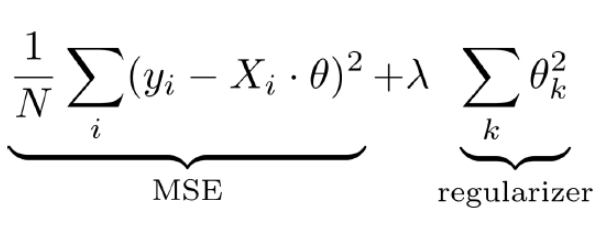

To implement the pipeline, we:
1. Iterate through various values of lambda
2. Fit a ridge regression model for each of these values
3. Evaluate the performance of this model on the validation set
4. Keep track of which model is the best we've seen so far (on the validation set)

In [224]:
from sklearn import linear_model

In [225]:
def MSE(model, X, y):
    predictions = model.predict(X)
    differences = [(a-b)**2 for (a,b) in zip(predictions,y)]
    return sum(differences) / len(differences)

In [226]:
# Variables to keep track of the current best model and MSE
bestModel = None 
bestMSE = None

In [227]:
for lamb in [0.01, 0.1, 1, 10, 100]:
    # Fit a model for each lambda value
    model = linear_model.Ridge(lamb, fit_intercept=False) 
    model.fit(X_train, y_train)
    
    mseTrain = MSE(model, X_train, y_train)
    mseValid = MSE(model, X_valid, y_valid)
    
    print("lambda = " + str(lamb) + ", training/validation error" + str(mseTrain) + '/' + str(mseValid))
    
    if not bestModel or mseValid < bestMSE:
        bestModel = model
        bestMSE = mseValid

lambda = 0.01, training/validation error[0.86022051]/[0.87735039]
lambda = 0.1, training/validation error[0.86022127]/[0.8773391]
lambda = 1, training/validation error[0.86025821]/[0.87728537]
lambda = 10, training/validation error[0.86046107]/[0.87739919]
lambda = 100, training/validation error[0.86099701]/[0.8794343]


In [228]:
mseTest = MSE(bestModel, X_test, y_test)
print("test error = " + str(mseTest))

test error = [0.85992539]


In [229]:
FVU = mseTest / np.var(y_test)
R2 = 1 - FVU
print("R2 = " + str(R2)) 

R2 = [0.02974691]


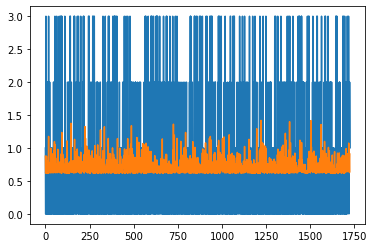

In [230]:
plt.figure()
plt.plot(y_test)
plt.plot(model.predict(X_test))
plt.show()

**Conclusion:** As we see, this problem can't be solve by a linear regression model because the features have an extreamly small value, so lets try to perform a classification in healthy and sick respiratory cycles

# Classification

In [275]:
df.loc[df['state'] != 0, 'state'] = True
df.loc[df['state'] == 0, 'state'] = False
df

,patient_ID,Diagnosis,age,sex,IMC,weight,height,adq_format,start,end,crackles,wheezes,state,Var,Range,Coarse_Av,Fine_Av,Spectrum Av
0,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,0.036,0.579,0,0,False,0.000048,0.113594,0.000446,0.000599,2.537207e-08
1,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,0.579,2.450,0,0,False,0.000066,0.159031,0.012435,-0.001276,3.532798e-08
2,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,2.450,3.893,0,0,False,0.000044,0.115345,-0.101963,-0.000701,2.213387e-08
3,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,3.893,5.793,0,0,False,0.000074,0.187316,-0.113660,-0.000223,3.485673e-08
4,101,URTI,3.0,F,NaN,19.0,99.0,1b1_Al_sc_Meditron,5.793,7.521,0,0,False,0.000036,0.117565,-0.017593,-0.001040,1.806783e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,11.721,13.693,1,0,True,0.000015,0.056514,-0.005161,-0.005630,7.528343e-09
6894,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,13.693,15.536,0,0,False,0.000026,0.107412,-0.018191,-0.000332,1.279829e-08
6895,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,15.536,17.493,0,0,False,0.000017,0.089678,0.002857,0.005618,8.751189e-09
6896,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1_Pl_sc_LittC2SE,17.493,19.436,1,0,True,0.000018,0.059962,-0.004191,0.002940,8.975479e-09


In [294]:
y_class = np.ravel(df['state'].values.reshape(-1,1).tolist())
y_class[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [295]:
modelLin = linear_model.LogisticRegression(max_iter=100, multi_class='ovr',n_jobs=1,solver='liblinear') #Basic Linear Model
modelLin.fit(X, y_class)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [296]:
predictions = modelLin.predict(X)
correct = predictions == y_class
correct

array([ True,  True,  True, ...,  True, False,  True])

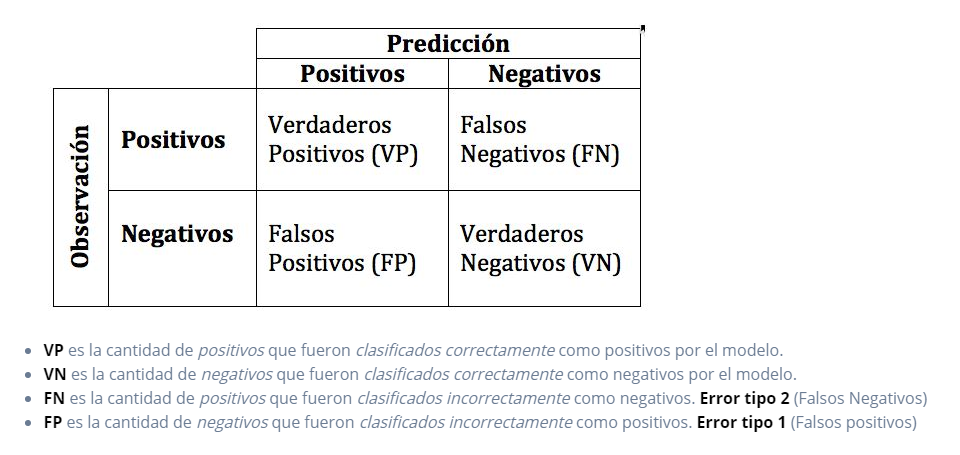

In [298]:
# p: Prediction                                                                                                            
# l: Label
TP = sum([(p and l) for (p,l) in zip(predictions, y_class)])
FP = sum([(p and not l) for (p,l) in zip(predictions, y_class)])
TN = sum([(not p and not l) for (p,l) in zip(predictions, y_class)])
FN = sum([(not p and l) for (p,l) in zip(predictions, y_class)])

In [299]:
print("TP = " + str(TP))
print("FP = " + str(FP))
print("TN = " + str(TN))
print("FN = " + str(FN))

TP = 218
FP = 180
TN = 3462
FN = 3038


In [300]:
TF_Accuracy = (TP + TN) / (TP + TN + FP + FN)
TF_Accuracy

0.5334879675268194

In [301]:
TPR = TP / (TP + FN) # Number of data that were positive, and that were labeled
TNR = TN / (TN + FP) # Number of data that were negative, and that were labeled
print(TPR, '\n',TNR)

0.06695331695331695 
 0.9505766062602965


In [302]:
BER = 1 - 1/2 * (TPR + TNR)
print("Balanced error rate = " + str(BER))

Balanced error rate = 0.49123503839319327


In [303]:
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

precision, recall

(0.5477386934673367, 0.06695331695331695)

In [304]:
F1 = 2 * (precision*recall) / (precision + recall)
F1

0.11932129173508484

# And in case of the True labels (sick respiratory cycles) are more important:

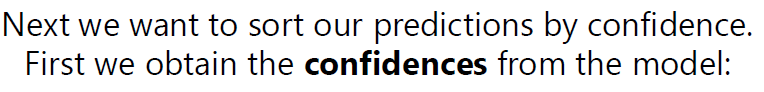

In [305]:
confidences = model.decision_function(X)
confidences

array([ 0.10262646,  0.07467153,  0.0549044 , ...,  0.17507139,
        0.06829087, -0.0267003 ])

Then we sort them along de with the labels

In [316]:
confidencesAndLabels = list(zip(confidences, y_class))
confidencesAndLabels[:5]

[(0.10262646118669831, False),
 (0.07467152887165264, False),
 (0.05490440262215493, False),
 (0.042249699355202536, False),
 (0.37435466720459515, False)]

In [307]:
confidencesAndLabels.sort()
confidencesAndLabels.reverse()

At this point we can discard the confidences

In [308]:
labelsRankedByConfidence = [z[1] for z in confidencesAndLabels]
labelsRankedByConfidence[:5]

[True, True, False, True, True]

In [309]:
def precisionAtK(K, y_sorted):
    return sum(y_sorted[:K]) / K

def recallAtK(K, y_sorted):
    return sum(y_sorted[:K]) / sum(y_sorted)

In [310]:
precisionAtK(50, labelsRankedByConfidence)

0.6

In [311]:
precisionAtK(1000, labelsRankedByConfidence)

0.504

In [312]:
precisionAtK(10000, labelsRankedByConfidence)

0.3256

In [313]:
recallAtK(50, labelsRankedByConfidence)

0.009213759213759214

In [314]:
recallAtK(1000, labelsRankedByConfidence)

0.1547911547911548

In [315]:
recallAtK(10000, labelsRankedByConfidence)

1.0

**Conclusion:** The performed model it more or less good, in the aproximately 50% of cases, it can predict the state of the respiratory cycle